Importing our libraries


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder, MinMaxScaler
import ast
from google.colab import drive
from sklearn.model_selection import train_test_split
from typing_extensions import Concatenate
from tensorflow.keras.layers import Input, Embedding, Concatenate, Dense
from tensorflow.keras.models import Model
from tensorflow.keras import layers, regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Lambda
import xgboost as xgb
from xgboost import XGBRegressor
import random
from sklearn.metrics import ndcg_score
from tensorflow.keras import regularizers

Now initializing our datasets,

In [ ]:

drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
  dataframe_interactions = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Game Recommendation System/interactions.csv")
dataframe_games = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Game Recommendation System/games.csv")

print("-------------------------\n")
display(dataframe_interactions.head())
print("-------------------------\n")
display(dataframe_games.head())

-------------------------



,151603712,The Elder Scrolls V Skyrim,purchase,1.0,0
0,151603712,The Elder Scrolls V Skyrim,play,273.0,0
1,151603712,Fallout 4,purchase,1.0,0
2,151603712,Fallout 4,play,87.0,0
3,151603712,Spore,purchase,1.0,0
4,151603712,Spore,play,14.9,0


-------------------------



,AppID,Name,Release date,Estimated owners,Peak CCU,Required age,Price,DiscountDLC count,About the game,Supported languages,...,Average playtime two weeks,Median playtime forever,Median playtime two weeks,Developers,Publishers,Categories,Genres,Tags,Screenshots,Movies
20200,Galactic Bowling,"Oct 21, 2008",0 - 20000,0,0,19.99,0,0,Galactic Bowling is an exaggerated and stylize...,['English'],...,0,0,0,Perpetual FX Creative,Perpetual FX Creative,"Single-player,Multi-player,Steam Achievements,...","Casual,Indie,Sports","Indie,Casual,Sports,Bowling",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
655370,Train Bandit,"Oct 12, 2017",0 - 20000,0,0,0.99,0,0,THE LAW!! Looks to be a showdown atop a train....,"['English', 'French', 'Italian', 'German', 'Sp...",...,0,0,0,Rusty Moyher,Wild Rooster,"Single-player,Steam Achievements,Full controll...","Action,Indie","Indie,Action,Pixel Graphics,2D,Retro,Arcade,Sc...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
1732930,Jolt Project,"Nov 17, 2021",0 - 20000,0,0,4.99,0,0,Jolt Project: The army now has a new robotics ...,"['English', 'Portuguese - Brazil']",...,0,0,0,Campião Games,Campião Games,Single-player,"Action,Adventure,Indie,Strategy",NaN,https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
1355720,Henosis™,"Jul 23, 2020",0 - 20000,0,0,5.99,0,0,HENOSIS™ is a mysterious 2D Platform Puzzler w...,"['English', 'French', 'Italian', 'German', 'Sp...",...,0,0,0,Odd Critter Games,Odd Critter Games,"Single-player,Full controller support","Adventure,Casual,Indie","2D Platformer,Atmospheric,Surreal,Mystery,Puzz...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
1139950,Two Weeks in Painland,"Feb 3, 2020",0 - 20000,0,0,0.00,0,0,ABOUT THE GAME Play as a hacker who has arrang...,"['English', 'Spanish - Spain']",...,0,0,0,Unusual Games,Unusual Games,"Single-player,Steam Achievements","Adventure,Indie","Indie,Adventure,Nudity,Violent,Sexual Content,...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...


We can see on the second dataset that its bugged and the columns don't match the correct rows.

Now, we will initialize our columns and clean our datasets to match each other.
We also need to move our second dataset's columns one tile to the left since it's bugged.

In [ ]:
dataframe_games.columns = dataframe_games.columns[1:].tolist() + ['_drop']
dataframe_games = dataframe_games.drop(columns=['_drop'])


dataframe_games["Name"] = dataframe_games["Name"].str.lower().str.replace(r"[^\w\s]", "", regex=True).str.strip()



dataframe_interactions.columns = ["User_Id","Name","Behaviour","Hours_Or_Purchase","0"]
dataframe_interactions= dataframe_interactions.drop("0", axis=1)

dataframe_interactions["Behaviour"] = dataframe_interactions["Behaviour"].str.strip().str.lower()

dataframe_interactions["Name"] = dataframe_interactions["Name"].str.lower().str.replace(r"[^\w\s]", "", regex=True).str.strip()


display(dataframe_interactions.head())
print("------------------------------")
display(dataframe_games.head())

,User_Id,Name,Behaviour,Hours_Or_Purchase
0,151603712,the elder scrolls v skyrim,play,273.0
1,151603712,fallout 4,purchase,1.0
2,151603712,fallout 4,play,87.0
3,151603712,spore,purchase,1.0
4,151603712,spore,play,14.9


------------------------------


,Name,Release date,Estimated owners,Peak CCU,Required age,Price,DiscountDLC count,About the game,Supported languages,Full audio languages,...,Average playtime two weeks,Median playtime forever,Median playtime two weeks,Developers,Publishers,Categories,Genres,Tags,Screenshots,Movies
20200,galactic bowling,"Oct 21, 2008",0 - 20000,0,0,19.99,0,0,Galactic Bowling is an exaggerated and stylize...,['English'],...,0,0,0,0,Perpetual FX Creative,Perpetual FX Creative,"Single-player,Multi-player,Steam Achievements,...","Casual,Indie,Sports","Indie,Casual,Sports,Bowling",https://cdn.akamai.steamstatic.com/steam/apps/...
655370,train bandit,"Oct 12, 2017",0 - 20000,0,0,0.99,0,0,THE LAW!! Looks to be a showdown atop a train....,"['English', 'French', 'Italian', 'German', 'Sp...",...,0,0,0,0,Rusty Moyher,Wild Rooster,"Single-player,Steam Achievements,Full controll...","Action,Indie","Indie,Action,Pixel Graphics,2D,Retro,Arcade,Sc...",https://cdn.akamai.steamstatic.com/steam/apps/...
1732930,jolt project,"Nov 17, 2021",0 - 20000,0,0,4.99,0,0,Jolt Project: The army now has a new robotics ...,"['English', 'Portuguese - Brazil']",...,0,0,0,0,Campião Games,Campião Games,Single-player,"Action,Adventure,Indie,Strategy",NaN,https://cdn.akamai.steamstatic.com/steam/apps/...
1355720,henosis,"Jul 23, 2020",0 - 20000,0,0,5.99,0,0,HENOSIS™ is a mysterious 2D Platform Puzzler w...,"['English', 'French', 'Italian', 'German', 'Sp...",...,0,0,0,0,Odd Critter Games,Odd Critter Games,"Single-player,Full controller support","Adventure,Casual,Indie","2D Platformer,Atmospheric,Surreal,Mystery,Puzz...",https://cdn.akamai.steamstatic.com/steam/apps/...
1139950,two weeks in painland,"Feb 3, 2020",0 - 20000,0,0,0.00,0,0,ABOUT THE GAME Play as a hacker who has arrang...,"['English', 'Spanish - Spain']",...,0,0,0,0,Unusual Games,Unusual Games,"Single-player,Steam Achievements","Adventure,Indie","Indie,Adventure,Nudity,Violent,Sexual Content,...",https://cdn.akamai.steamstatic.com/steam/apps/...


We will use the tags on the second dataset as our features  (X) for our Collaborative filtering algorithm so we need to make the tags its own dataframe.

We will start by cleaning the tags,

In [ ]:
dataframe_games["Genres"] = dataframe_games["Genres"].fillna("")
dataframe_games["Tags"] = dataframe_games["Tags"].fillna("")

def clean_tags(x):
    return [tag.strip().lower() for tag in x.split(",") if tag.strip()]

dataframe_games["genre_list"] = dataframe_games["Genres"].apply(clean_tags)
dataframe_games["tag_list"] = dataframe_games["Tags"].apply(clean_tags)
display(dataframe_games.head())

,Name,Release date,Estimated owners,Peak CCU,Required age,Price,DiscountDLC count,About the game,Supported languages,Full audio languages,...,Median playtime two weeks,Developers,Publishers,Categories,Genres,Tags,Screenshots,Movies,genre_list,tag_list
20200,galactic bowling,"Oct 21, 2008",0 - 20000,0,0,19.99,0,0,Galactic Bowling is an exaggerated and stylize...,['English'],...,0,0,Perpetual FX Creative,Perpetual FX Creative,"Single-player,Multi-player,Steam Achievements,...","Casual,Indie,Sports","Indie,Casual,Sports,Bowling",https://cdn.akamai.steamstatic.com/steam/apps/...,"[single-player, multi-player, steam achievemen...","[casual, indie, sports]"
655370,train bandit,"Oct 12, 2017",0 - 20000,0,0,0.99,0,0,THE LAW!! Looks to be a showdown atop a train....,"['English', 'French', 'Italian', 'German', 'Sp...",...,0,0,Rusty Moyher,Wild Rooster,"Single-player,Steam Achievements,Full controll...","Action,Indie","Indie,Action,Pixel Graphics,2D,Retro,Arcade,Sc...",https://cdn.akamai.steamstatic.com/steam/apps/...,"[single-player, steam achievements, full contr...","[action, indie]"
1732930,jolt project,"Nov 17, 2021",0 - 20000,0,0,4.99,0,0,Jolt Project: The army now has a new robotics ...,"['English', 'Portuguese - Brazil']",...,0,0,Campião Games,Campião Games,Single-player,"Action,Adventure,Indie,Strategy",NaN,https://cdn.akamai.steamstatic.com/steam/apps/...,[single-player],"[action, adventure, indie, strategy]"
1355720,henosis,"Jul 23, 2020",0 - 20000,0,0,5.99,0,0,HENOSIS™ is a mysterious 2D Platform Puzzler w...,"['English', 'French', 'Italian', 'German', 'Sp...",...,0,0,Odd Critter Games,Odd Critter Games,"Single-player,Full controller support","Adventure,Casual,Indie","2D Platformer,Atmospheric,Surreal,Mystery,Puzz...",https://cdn.akamai.steamstatic.com/steam/apps/...,"[single-player, full controller support]","[adventure, casual, indie]"
1139950,two weeks in painland,"Feb 3, 2020",0 - 20000,0,0,0.00,0,0,ABOUT THE GAME Play as a hacker who has arrang...,"['English', 'Spanish - Spain']",...,0,0,Unusual Games,Unusual Games,"Single-player,Steam Achievements","Adventure,Indie","Indie,Adventure,Nudity,Violent,Sexual Content,...",https://cdn.akamai.steamstatic.com/steam/apps/...,"[single-player, steam achievements]","[adventure, indie]"


Now we will turn the tag_list column to a one hot encoded version

Initialize the MultiLabelBinarizer and transform the list into a matrix

In [ ]:
mlb_genres = MultiLabelBinarizer()
mlb_tags = MultiLabelBinarizer()
genres_matrix = mlb_genres.fit_transform(dataframe_games["genre_list"])
tags_matrix = mlb_tags.fit_transform(dataframe_games["tag_list"])
display(genres_matrix)
display(tags_matrix)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0]])

Now we will convert the matrix into a dataframe and add the game name

In [ ]:
df_genres = pd.DataFrame(genres_matrix, columns=mlb_genres.classes_)
df_tags = pd.DataFrame(tags_matrix, columns=mlb_tags.classes_)
df_genres["Name"] = dataframe_games["Name"].values
df_tags["Name"] = dataframe_games["Name"].values
display(df_genres.head())
display(df_tags.head())

,captions available,co-op,commentary available,cross-platform multiplayer,family sharing,full controller support,hdr available,in-app purchases,includes level editor,includes source sdk,...,steam turn notifications,steam workshop,steamvr collectibles,tracked controller support,tracked motion controller support,valve anti-cheat enabled,vr only,vr support,vr supported,Name
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,galactic bowling
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,train bandit
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,jolt project
3,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,henosis
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,two weeks in painland


,360 video,accounting,action,adventure,animation & modeling,audio production,casual,design & illustration,documentary,early access,...,simulation,software training,sports,strategy,tutorial,utilities,video production,violent,web publishing,Name
0,0,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,galactic bowling
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,train bandit
2,0,0,1,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,jolt project
3,0,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,henosis
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,two weeks in painland


We also need a copy of the games dataframes that includes exclusively behavior==play data

In [ ]:
df_played = dataframe_interactions[dataframe_interactions["Behaviour"]=="play"]
display(df_played.head())

,User_Id,Name,Behaviour,Hours_Or_Purchase
0,151603712,the elder scrolls v skyrim,play,273.0
2,151603712,fallout 4,play,87.0
4,151603712,spore,play,14.9
6,151603712,fallout new vegas,play,12.1
8,151603712,left 4 dead 2,play,8.9


Now we can merge our datasets for later use

In [ ]:
df_merged = pd.merge(df_played, df_genres, on="Name", how="inner")
df_merged = pd.merge(df_merged, df_tags, on = "Name", how="inner")

df_merged = df_merged[df_merged['Name'] != "marvel puzzle quest"]

display(df_merged.head())

,User_Id,Name,Behaviour,Hours_Or_Purchase,captions available,co-op,commentary available,cross-platform multiplayer,family sharing,full controller support,...,short,simulation,software training,sports,strategy,tutorial,utilities,video production,violent,web publishing
0,151603712,the elder scrolls v skyrim,play,273.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,151603712,fallout 4,play,87.0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,151603712,spore,play,14.9,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
3,151603712,fallout new vegas,play,12.1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,151603712,left 4 dead 2,play,8.9,1,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0


Now we need to normalize the hours so that it doesnt overwhelm the model.
There are huge outliers so we need to normalize it further.

In [ ]:
df_merged["score"] = np.log1p(df_merged["Hours_Or_Purchase"])

scaler = MinMaxScaler()

df_merged["score"] = scaler.fit_transform(df_merged[["score"]])



display(df_merged.sample(5))

,User_Id,Name,Behaviour,Hours_Or_Purchase,captions available,co-op,commentary available,cross-platform multiplayer,family sharing,full controller support,...,simulation,software training,sports,strategy,tutorial,utilities,video production,violent,web publishing,score
1998,25096601,halflife 2 episode two,play,0.1,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0.000000
63835,15701750,alien swarm,play,0.2,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.009380
57869,26762388,shatter,play,5.1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.184653
448,11373749,team fortress 2,play,762.0,1,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0.705200
4127,64787956,space engineers,play,34.0,0,1,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0.372981


In [ ]:
df_merged = df_merged[df_merged["Name"] != "action gameplay recording and streaming"].reset_index(drop=True)

Test split


In [ ]:
from sklearn.model_selection import train_test_split as sk_train_test_split

def train_test_split_A(df, test_size, seed=42):
  train_parts = []
  test_parts = []
  for u, group in df.groupby("User_Id"):
    if len(group) < 2:
      train_parts.append(group)
      continue
    tr, test = sk_train_test_split(group, test_size=test_size, random_state=seed)
    train_parts.append(tr)
    test_parts.append(test)

  return pd.concat(train_parts).reset_index(drop=True), pd.concat(test_parts).reset_index(drop=True)

df_merged_train, df_merged_test = train_test_split(df_merged, test_size=0.1)

In [ ]:
game_encoder = LabelEncoder().fit(df_merged_train["Name"])
user_encoder = LabelEncoder().fit(df_merged_train["User_Id"])

df_merged_train["user_idx"] = user_encoder.transform(df_merged_train["User_Id"])
df_merged_train["game_idx"] = game_encoder.transform(df_merged_train["Name"])

df_merged_test = df_merged_test[
    df_merged_test["User_Id"].isin(user_encoder.classes_) &
    df_merged_test["Name"].isin(game_encoder.classes_)
].copy()

df_merged_test["user_idx"] = user_encoder.transform(df_merged_test["User_Id"])
df_merged_test["game_idx"] = game_encoder.transform(df_merged_test["Name"])

display(df_merged_train.sample(5))
display(df_merged_test.sample(5))

,User_Id,Name,Behaviour,Hours_Or_Purchase,captions available,co-op,commentary available,cross-platform multiplayer,family sharing,full controller support,...,sports,strategy,tutorial,utilities,video production,violent,web publishing,score,user_idx,game_idx
4605,102825821,warframe,play,6.8,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0.211154,2580,2462
47554,59662830,prototype,play,5.8,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.196364,1214,1630
65457,150033540,tomb raider,play,2.0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0.108153,4370,2337
62887,152419713,left 4 dead,play,19.4,1,1,1,0,0,1,...,0,0,0,0,0,0,0,0.314791,4462,1205
1045,94088853,need for speed hot pursuit,play,23.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.332310,2269,1418


,User_Id,Name,Behaviour,Hours_Or_Purchase,captions available,co-op,commentary available,cross-platform multiplayer,family sharing,full controller support,...,sports,strategy,tutorial,utilities,video production,violent,web publishing,score,user_idx,game_idx
53941,105243827,red orchestra ostfront 4145,play,0.8,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.053087,2667,1704
20432,86055705,hack n slash,play,0.2,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0.009380,1990,978
53746,134213189,counterstrike source,play,1.2,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0.074719,3735,458
61452,45292137,call of duty black ops ii,play,10.5,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0.253003,860,331
56368,81170946,call of duty black ops,play,9.3,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0.241123,1822,330


In [ ]:

df_merged_train = (
    df_merged_train
      .sort_values(
          ["user_idx", "game_idx", "Hours_Or_Purchase", "score"],
          ascending=[True, True, False, False]
      )
      .drop_duplicates(["user_idx", "game_idx"], keep="first")
      .reset_index(drop=True)
)

df_merged_test = (
    df_merged_test
      .sort_values(
          ["user_idx", "game_idx", "Hours_Or_Purchase", "score"],
          ascending=[True, True, False, False]
      )
      .drop_duplicates(["user_idx", "game_idx"], keep="first")
      .reset_index(drop=True)
)

display(df_merged_train.duplicated(["user_idx", "game_idx"]).sum() == 0)
display(df_merged_test.duplicated(["user_idx", "game_idx"]).sum() == 0)


np.True_

np.True_

Number of users and games and features for later use

In [ ]:
num_users = df_merged_train["user_idx"].nunique()
num_games = df_merged_train["game_idx"].nunique()
num_content = df_merged_train.drop(columns=["User_Id", "Name", "Behaviour",
                                   "Hours_Or_Purchase", "user_idx", "game_idx","score"]).shape[1]

display(f"Number of users: {num_users}")
display(f"Number of games: {num_games}")
display(f"Number of content: {num_content}")

'Number of users: 9919'

'Number of games: 2578'

'Number of content: 76'

In [ ]:
num_features_L = 30

Initializing Y and R for later calculations

In [ ]:
Y = np.zeros((num_users, num_games), dtype = np.float32)  #Will be hours
R = np.zeros((num_users, num_games), dtype = np.float32)  #Will be whether the user played the game or not

for row in df_merged_train.itertuples():
    Y[row.user_idx, row.game_idx] = row.score
    R[row.user_idx, row.game_idx] = 1

Y = tf.constant(Y, dtype=tf.float32)
R = tf.constant(R, dtype=tf.float32)

Splitting df to train and val sets


In [ ]:
train_indices, val_indices = sk_train_test_split(np.argwhere(R == 1), test_size=0.2, random_state=42)

R_train = np.zeros_like(R)
R_val = np.zeros_like(R)

for i, j in train_indices:
    R_train[i, j] = 1
for i, j in val_indices:
    R_val[i, j] = 1


And filter out users that didn't interact with a lot of games

In [ ]:
user_interaction_counts = tf.reduce_sum(R_train, axis=1)
active_user_mask = user_interaction_counts >= 10

Initalizing X W and b for later calculations (random at first)

In [ ]:
X = tf.Variable(tf.random.normal([num_users, num_features_L+num_content], stddev=0.1, dtype=tf.float32))

b = tf.Variable(tf.zeros([num_games], dtype=tf.float32))

user_bias = tf.Variable(tf.zeros([num_users], dtype=tf.float32))


W_latent = tf.Variable(tf.random.normal([num_games, num_features_L], stddev=0.1, dtype=tf.float32))
W_content = tf.Variable(tf.random.normal([num_games, num_content], stddev=0.1, dtype=tf.float32))


Now we need to write our cost function

In [ ]:
def cofi_cost_function(X,Y,R,W_latent,W_content,b,user_bias,lambda_,user_mask=None):
    if user_mask is not None:
        X = tf.boolean_mask(X, user_mask)
        Y = tf.boolean_mask(Y, user_mask)
        R = tf.boolean_mask(R, user_mask)
        user_bias = tf.boolean_mask(user_bias, user_mask)

    W_combined = tf.concat([W_latent, W_content], axis=1)
    mat  = tf.matmul(X, W_combined, transpose_b=True)
    pred = mat + tf.reshape(b, [1, -1]) + tf.reshape(user_bias, [-1, 1])

    Y = tf.cast(tf.reshape(Y, tf.shape(pred)), tf.float32)
    R = tf.cast(tf.reshape(R, tf.shape(pred)), tf.float32)
    pred = tf.cast(pred, tf.float32)

    error = (Y - pred) * R
    cost = 1/2 * tf.reduce_sum(tf.square(error))


    cost += (lambda_/2) * (tf.reduce_sum(tf.square(X))+tf.reduce_sum(tf.square(W_latent))+tf.reduce_sum(tf.square(W_content))+tf.reduce_sum(tf.square(b))+tf.reduce_sum(tf.square(user_bias)))
    return cost


In [ ]:
def mse_metric(X,Y,R,W,b,user_bias,user_mask=None):
    if user_mask is not None:
        X = tf.boolean_mask(X, user_mask)
        Y = tf.boolean_mask(Y, user_mask)
        R = tf.boolean_mask(R, user_mask)
        user_bias = tf.boolean_mask(user_bias,user_mask)



    mat = tf.matmul(X, W, transpose_b=True)
    pred = mat + tf.reshape(b, [1, -1]) + tf.reshape(user_bias, [-1, 1])

    Y = tf.cast(tf.reshape(Y, tf.shape(pred)), tf.float32)
    R = tf.cast(tf.reshape(R, tf.shape(pred)), tf.float32)
    pred = tf.cast(pred, tf.float32)

    error = (Y - pred) * R
    mse = tf.reduce_sum(tf.square(error)) / (tf.reduce_sum(R)+1e-8)
    return mse

Initialize iterations and lambda_ and optimizer and losses(for later plotting) and the mask bug fix

In [ ]:
iterations = 100
lambda_ = 0.33
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
min_delta = 0.001 #unused for now
losses = []
val_losses = []
mse_plot = []

active_user_indices = np.where(active_user_mask.numpy())[0]

X_filtered = tf.Variable(tf.boolean_mask(X, active_user_mask))

Now its time to actually train our model

In [ ]:
for iter in range(iterations):
  with tf.GradientTape() as tape:
    cost_value = cofi_cost_function(X,Y,R_train
                                    ,W_latent,W_content,
                                    b,user_bias,
                                    lambda_, user_mask = active_user_mask)

  grads = tape.gradient(cost_value, [X,W_latent,W_content,b,user_bias])
  optimizer.apply_gradients(zip(grads, [X, W_latent,W_content, b,user_bias]))

  val_cost_value = cofi_cost_function(X,Y,R_val,W_latent,W_content,b,user_bias,lambda_=0, user_mask = active_user_mask)
  val_losses.append(val_cost_value.numpy())
  losses.append(cost_value.numpy())

  W_combined = tf.concat([W_latent, W_content], axis=1)
  mse_value = mse_metric(X,Y,R_val,W_combined,b,user_bias,user_mask = active_user_mask)
  mse_plot.append(mse_value)

  if iter % 20 == 0:
    print(f"Training loss at iteration {iter}: {cost_value.numpy():.4f}\n")
    print(f"Validation loss at iteration {iter}: {val_cost_value.numpy():.4f}\n")
    print(f"MSE at iteration {iter}: {mse_value.numpy():.4f}\n")


Training loss at iteration 0: 1602.3159

Validation loss at iteration 0: 213.8058

MSE at iteration 0: 0.0701

Training loss at iteration 20: 167.0612

Validation loss at iteration 20: 81.7919

MSE at iteration 20: 0.0268

Training loss at iteration 40: 93.0931

Validation loss at iteration 40: 62.7618

MSE at iteration 40: 0.0206

Training loss at iteration 60: 79.9194

Validation loss at iteration 60: 59.4996

MSE at iteration 60: 0.0195

Training loss at iteration 80: 76.5777

Validation loss at iteration 80: 58.6344

MSE at iteration 80: 0.0192



Plotting our loss function

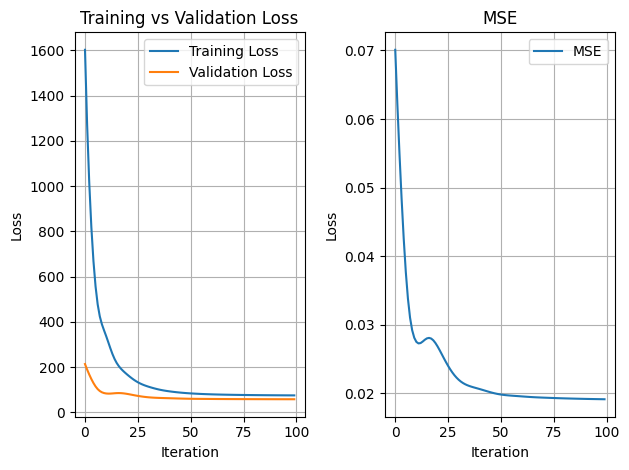

In [ ]:
plt.subplot(1, 2, 1)
plt.plot(losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)


plt.subplot(1,2,2)
plt.plot(mse_plot,label="MSE")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("MSE")
plt.legend()
plt.grid(True)


plt.tight_layout()
plt.show()


Now time to predict ratings for a single user

In [ ]:
display(df_merged_train.sample(20))

,User_Id,Name,Behaviour,Hours_Or_Purchase,captions available,co-op,commentary available,cross-platform multiplayer,family sharing,full controller support,...,sports,strategy,tutorial,utilities,video production,violent,web publishing,score,user_idx,game_idx
1358,8776918,call of duty black ops ii,play,1.8,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0.100715,118,331
42277,189858084,far cry,play,0.5,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.033434,6239,774
45332,216059509,team fortress 2,play,38.0,1,0,1,1,0,0,...,0,0,0,0,0,0,0,0.384646,7413,2140
1555,9563573,torchlight ii,play,50.0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0.413564,131,2345
29107,113124720,unturned,play,3.6,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0.154230,2970,2410
18112,66687732,portal,play,6.5,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0.206926,1408,1589
44415,206414060,dota 2,play,1.3,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0.079511,7041,619
13578,53826748,left 4 dead,play,6.9,1,1,1,0,0,1,...,0,0,0,0,0,0,0,0.212527,1057,1205
17380,65117175,portal 2,play,11.3,1,1,1,0,0,1,...,0,0,0,0,0,0,0,0.260252,1349,1590
18482,68685708,counterstrike global offensive,play,533.0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0.666732,1458,457


Lets look at a player's every interaction

In [ ]:
user_bias_filtered = tf.boolean_mask(user_bias, active_user_mask)
pred_ratings = (
    tf.matmul(X_filtered, W_combined, transpose_b=True) +
    tf.reshape(b, [1, -1])  +
    tf.reshape(user_bias_filtered, [-1,1])
        )

In [ ]:
user_idx = 	2598

if user_idx not in active_user_indices:
    print("User is not in the active training set.")
    user_interactions = df_merged_train[df_merged_train['user_idx']==user_idx]
    user_interactions_sorted = user_interactions.sort_values(by="Hours_Or_Purchase", ascending=False).reset_index(drop=True)
    user_games_indices = df_merged_train[df_merged_train['user_idx']== user_idx]["game_idx"].values
    display(user_interactions_sorted.head(30))

    if len(user_games_indices)>0:
      user_vector = tf.reduce_mean(
        tf.gather(W_combined, user_games_indices), axis=0, keepdims=True
      )

      user_preds = (
          tf.matmul(user_vector, W_combined, transpose_b=True)
          + tf.reshape(b, [1,-1])

      ).numpy().flatten()

    else:
      print("No interactions found. Falling back to global popularity.")
      user_preds = np.reshape(b, [-1]).numpy()

else:

    user_interactions = df_merged_train[df_merged_train["user_idx"] == user_idx]
    user_interactions_sorted = user_interactions.sort_values(by="Hours_Or_Purchase", ascending=False).reset_index(drop=True)

    display(user_interactions_sorted.head(45))

    filtered_user_idx = np.where(active_user_indices == user_idx)[0][0]
    user_preds = pred_ratings[filtered_user_idx].numpy()

,User_Id,Name,Behaviour,Hours_Or_Purchase,captions available,co-op,commentary available,cross-platform multiplayer,family sharing,full controller support,...,sports,strategy,tutorial,utilities,video production,violent,web publishing,score,user_idx,game_idx
0,103371488,the elder scrolls v skyrim,play,274.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.595195,2598,2194
1,103371488,grand theft auto v,play,260.0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0.589563,2598,928
2,103371488,torchlight ii,play,98.0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0.485065,2598,2345
3,103371488,the witcher 2 assassins of kings enhanced edition,play,89.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.474790,2598,2284
4,103371488,counterstrike global offensive,play,51.0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0.415657,2598,457
5,103371488,the witcher 3 wild hunt,play,41.0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0.392634,2598,2285
6,103371488,portal,play,33.0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0.369856,2598,1589
7,103371488,portal 2,play,30.0,1,1,1,0,0,1,...,0,0,0,0,0,0,0,0.359898,2598,1590
8,103371488,grand theft auto episodes from liberty city,play,25.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.340938,2598,925
9,103371488,payday 2,play,5.1,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0.184653,2598,1541


And recommending the games

In [ ]:
played_indices = set(user_interactions["game_idx"])
recommendations = [(i, score) for i, score in enumerate(user_preds) if i not in played_indices]
recommendations = sorted(recommendations, key=lambda x: x[1], reverse=True)[:20]
display(recommendations)

[(770, np.float32(0.55274934)),
 (287, np.float32(0.5258887)),
 (1800, np.float32(0.45229104)),
 (1322, np.float32(0.4152889)),
 (847, np.float32(0.40727332)),
 (1368, np.float32(0.39899886)),
 (505, np.float32(0.39715847)),
 (46, np.float32(0.39144823)),
 (288, np.float32(0.38975364)),
 (506, np.float32(0.3882892)),
 (2470, np.float32(0.3842986)),
 (1340, np.float32(0.38212657)),
 (597, np.float32(0.37896398)),
 (187, np.float32(0.37337068)),
 (1334, np.float32(0.37117025)),
 (1415, np.float32(0.36834678)),
 (670, np.float32(0.36590922)),
 (782, np.float32(0.36261192)),
 (2538, np.float32(0.36180428)),
 (235, np.float32(0.36111426))]

And making them user readable

In [ ]:
for i, score in recommendations:
    game_name = game_encoder.inverse_transform([i])[0]
    unscaled = scaler.inverse_transform([[score]])[0,0]
    predicted_hours = np.expm1(unscaled)
    print(f"{game_name} - predicted hours: {predicted_hours:.1f}")

fallout 4 - predicted hours: 184.5
borderlands 2 - predicted hours: 143.6
rust - predicted hours: 72.0
metal gear solid v the phantom pain - predicted hours: 50.8
freaking meatbags - predicted hours: 47.1
mortal kombat x - predicted hours: 43.6
dark souls ii - predicted hours: 42.8
action  gameplay recording and streaming - predicted hours: 40.5
borderlands the presequel - predicted hours: 39.9
dark souls ii scholar of the first sin - predicted hours: 39.3
warhammer 40000 dawn of war ii - predicted hours: 37.9
might  magic heroes vi - predicted hours: 37.1
dishonored - predicted hours: 36.0
baldurs gate ii enhanced edition - predicted hours: 34.1
middleearth shadow of mordor - predicted hours: 33.4
nba 2k16 - predicted hours: 32.5
dying light - predicted hours: 31.8
farming simulator 15 - predicted hours: 30.8
xcom enemy unknown - predicted hours: 30.6
bioshock infinite - predicted hours: 30.4


Lets do content based filtering with deep learning

In [ ]:
meta_columns = ['Name','avg_playtime','user_idx','Hours_Or_Purchase','game_idx','User_Id','Behaviour','avg_playtime_norm','score']

feature_columns = [
    col for col in df_merged_train.columns
    if col not in meta_columns
]
clean_feature_columns = [col.replace("_y", "") for col in feature_columns]

game_features = df_merged_train[["game_idx"] + feature_columns].drop_duplicates("game_idx").set_index("game_idx")

game_features.columns = clean_feature_columns

display(game_features.head())
display(clean_feature_columns)


,captions available,co-op,commentary available,cross-platform multiplayer,family sharing,full controller support,hdr available,in-app purchases,includes level editor,includes source sdk,...,short,simulation,software training,sports,strategy,tutorial,utilities,video production,violent,web publishing
game_idx,,,,,,,,,,,,,,,,,,,,,
82,1,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
619,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
1590,1,1,1,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2140,1,0,1,1,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
189,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0


['captions available',
 'co-op',
 'commentary available',
 'cross-platform multiplayer',
 'family sharing',
 'full controller support',
 'hdr available',
 'in-app purchases',
 'includes level editor',
 'includes source sdk',
 'lan co-op',
 'lan pvp',
 'mmo',
 'mods',
 'mods (require hl2)',
 'multi-player',
 'online co-op',
 'online pvp',
 'partial controller support',
 'pvp',
 'remote play on phone',
 'remote play on tablet',
 'remote play on tv',
 'remote play together',
 'shared/split screen',
 'shared/split screen co-op',
 'shared/split screen pvp',
 'single-player',
 'stats',
 'steam achievements',
 'steam cloud',
 'steam leaderboards',
 'steam timeline',
 'steam trading cards',
 'steam turn notifications',
 'steam workshop',
 'steamvr collectibles',
 'tracked controller support',
 'tracked motion controller support',
 'valve anti-cheat enabled',
 'vr only',
 'vr support',
 'vr supported',
 '360 video',
 'accounting',
 'action',
 'adventure',
 'animation & modeling',
 'audio produc

In [ ]:
user_profiles = (
    df_merged_train
      .groupby("user_idx")
      .apply(lambda x: (game_features.loc[x["game_idx"]].values.T @ x["score"].values) / (x["score"].sum()+1e-8))
)

user_profiles = pd.DataFrame(
    user_profiles.tolist(),
    index=user_profiles.index,
    columns=clean_feature_columns
)


display(user_profiles)

/tmp/ipython-input-3322345286.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: (game_features.loc[x["game_idx"]].values.T @ x["score"].values) / (x["score"].sum()+1e-8))


,captions available,co-op,commentary available,cross-platform multiplayer,family sharing,full controller support,hdr available,in-app purchases,includes level editor,includes source sdk,...,short,simulation,software training,sports,strategy,tutorial,utilities,video production,violent,web publishing
user_idx,,,,,,,,,,,,,,,,,,,,,
0,0.982040,0.898350,0.635354,0.101650,0.0,0.533704,0.0,0.119609,0.982040,0.000000,...,0.0,0.000000,0.0,0.0,0.017960,0.0,0.0,0.0,0.0,0.0
1,0.116071,0.506720,0.086044,0.101647,0.0,0.116071,0.0,0.000000,0.086044,0.101647,...,0.0,0.158454,0.0,0.0,0.166205,0.0,0.0,0.0,0.0,0.0
2,0.139468,0.564005,0.139468,0.243517,0.0,0.528405,0.0,0.000000,0.004261,0.139468,...,0.0,0.000000,0.0,0.0,0.173457,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.000000,1.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9914,0.000000,1.000000,0.000000,1.000000,0.0,1.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
9915,0.202174,0.481606,0.202174,0.202174,0.0,0.000000,0.0,0.683780,0.715408,0.000000,...,0.0,0.202174,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
9916,0.000000,1.000000,0.000000,0.000000,0.0,0.000000,0.0,1.000000,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.0


In [ ]:
train_df = df_merged_train.copy()

X_user = user_profiles.loc[train_df["user_idx"]].values
X_game = game_features.loc[train_df["game_idx"]].values
y = train_df["score"].values

n_features = X_user.shape[1]

user_input = layers.Input(shape=(n_features,), name="user_features")
game_input = layers.Input(shape=(n_features,), name="game_features")

user_vec = layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l1_l2(l1=1e-6, l2=1e-5))(user_input)
user_vec = layers.Dense(64, activation="relu", kernel_regularizer=regularizers.l2(1e-5))(user_vec)

game_vec = layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l1_l2(l1=1e-6, l2=1e-5))(game_input)
game_vec = layers.Dense(64, activation="relu", kernel_regularizer=regularizers.l2(1e-5))(game_vec)

x = layers.Concatenate()([user_vec, game_vec])
x = layers.Dense(64, activation="relu", kernel_regularizer=regularizers.l2(1e-5))(x)
x = layers.Dense(32, activation="relu", kernel_regularizer=regularizers.l2(1e-5))(x)
output = layers.Dense(1)(x)

model = Model(inputs=[user_input, game_input], outputs=output)
model.compile(optimizer="adam", loss="mse", metrics=["mae"])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user_features       │ (None, 76)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ game_features       │ (None, 76)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │      9,856 │ user_features[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │      9,856 │ game_features[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 64)        │      8,256 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128)       │          0 │ dense_1[0][0],    │
│ (Concatenate)       │                   │            │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 64)        │      8,256 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 32)        │      2,080 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 1)         │         33 │ dense_5[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 46,593 (182.00 KB)

 Trainable params: 46,593 (182.00 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    [X_user, X_game], y,
    batch_size=256,
    epochs=25,
    validation_split=0.2,
    shuffle=True
)

Epoch 1/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - loss: 0.0344 - mae: 0.1334 - val_loss: 0.0365 - val_mae: 0.1480
Epoch 2/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0263 - mae: 0.1170 - val_loss: 0.0318 - val_mae: 0.1370
Epoch 3/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0250 - mae: 0.1143 - val_loss: 0.0442 - val_mae: 0.1583
Epoch 4/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0245 - mae: 0.1127 - val_loss: 0.0283 - val_mae: 0.1254
Epoch 5/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0237 - mae: 0.1110 - val_loss: 0.0288 - val_mae: 0.1269
Epoch 6/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0229 - mae: 0.1089 - val_loss: 0.0329 - val_mae: 0.1368
Epoch 7/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0232 - mae: 0.1102 - val_loss: 0.0299 - val_mae: 0.1315
Epoch 8/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0222 - mae: 0.1073 - val_loss: 0.0331 - val_mae: 0.1354
Epoch 9/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - 

In [ ]:
def recommend_games_dl(user_id, model, user_profiles, game_features, game_lookup, df, scaler, top_n):

    user_vec = np.repeat(user_profiles.loc[user_id].values.reshape(1, -1), len(game_features), axis=0)
    game_vecs = game_features.values


    preds = model.predict([user_vec, game_vecs], verbose=0).flatten()

    played_games = df.loc[df["user_idx"] == user_id, "game_idx"].unique()
    mask = ~game_features.index.isin(played_games)

    preds_filtered = preds[mask]
    candidate_game_ids = game_features.index[mask]



    top_idx = np.argsort(preds_filtered)[::-1][:top_n]
    top_game_ids = candidate_game_ids[top_idx]
    top_scores = preds_filtered[top_idx]

    top_scores_log = scaler.inverse_transform(top_scores.reshape(-1, 1)).flatten()
    top_hours = np.expm1(top_scores_log)


    results = list(zip(game_lookup.loc[top_game_ids, "Name"], top_hours))

    return results



In [ ]:
game_lookup = df_merged_train[["game_idx", "Name"]].drop_duplicates().set_index("game_idx")


recommendations = recommend_games_dl(2598, model, user_profiles=user_profiles, game_features=game_features, game_lookup=game_lookup, df=df_merged_train, scaler=scaler, top_n=20)

print("Recommendations for user:")
for i, (game,hours) in enumerate(recommendations, 1):
    print(f"{i}. {game}, predicted hours: {hours:.1f}")

Recommendations for user:
1. fallout 4, predicted hours: 103.6
2. borderlands 2, predicted hours: 69.1
3. dark souls ii scholar of the first sin, predicted hours: 55.3
4. dark souls ii, predicted hours: 55.3
5. metal gear solid v the phantom pain, predicted hours: 45.2
6. borderlands the presequel, predicted hours: 44.7
7. fairy fencer f, predicted hours: 44.6
8. mount  blade warband, predicted hours: 39.2
9. fallout new vegas, predicted hours: 37.5
10. pillars of eternity, predicted hours: 37.4
11. fable anniversary, predicted hours: 36.9
12. team fortress 2, predicted hours: 35.1
13. nba 2k16, predicted hours: 30.4
14. final fantasy xiii, predicted hours: 29.1
15. farming simulator 15, predicted hours: 27.9
16. the binding of isaac rebirth, predicted hours: 27.4
17. hurtworld, predicted hours: 26.8
18. sid meiers civilization v, predicted hours: 26.0
19. elite dangerous, predicted hours: 25.6
20. dying light, predicted hours: 23.7


XGBoost algorithm to combine the two model outputs

In [ ]:
def generate_cf_predictions(df_pairs, active_user_indices, pred_ratings, W_combined, b, user_bias):

    preds = []
    act_set = set(active_user_indices.tolist())

    for _, row in df_pairs.iterrows():
        u = int(row["user_idx"])
        g = int(row["game_idx"])

        if u in act_set:
            filtered_user_idx = np.where(active_user_indices == u)[0][0]
            preds.append(float(pred_ratings[filtered_user_idx, g].numpy()))
        else:
            user_games_indices = df_merged_train.loc[df_merged_train["user_idx"] == u, "game_idx"].astype(int).values
            if len(user_games_indices) > 0:
                user_vector = tf.reduce_mean(tf.gather(W_combined, user_games_indices), axis=0, keepdims=True)
                score = (tf.matmul(user_vector, W_combined, transpose_b=True) + tf.reshape(b, [1, -1])).numpy().flatten()[g]
                preds.append(float(score))
            else:
                preds.append(float(b.numpy()[g]))

    return np.array(preds, dtype=np.float32)


In [ ]:
def generate_dl_predictions(df_pairs, model, user_profiles, game_features):

    user_vecs = user_profiles.loc[df_pairs["user_idx"]].values
    game_vecs = game_features.loc[df_pairs["game_idx"]].values

    preds = model.predict([user_vecs, game_vecs], verbose=0).flatten()
    return preds

In [ ]:
def build_train_pairs(df_pos, user_profiles, game_features, num_negatives, scaler, random_state=42):
    rng = np.random.default_rng(random_state)
    pairs = []

    all_games = set(game_features.index.astype(int))

    y_neg = float(scaler.transform(np.array([[0.0]])).ravel()[0])

    for u, grp in df_pos.groupby("user_idx"):
        played = set(grp["game_idx"].astype(int).values)
        not_played = np.array(list(all_games - played), dtype=int)


        for g, score in zip(grp["game_idx"].astype(int).values, grp["score"].values):
            pairs.append({
                "user_idx": int(u),
                "game_idx": int(g),
                "score": float(score)
            })

        if len(not_played) > 0 and num_negatives > 0:
            k = min(num_negatives, len(not_played))
            sampled = rng.choice(not_played, size=k, replace=False)
            for g in sampled:
                pairs.append({
                    "user_idx": int(u),
                    "game_idx": int(g),
                    "score": y_neg
                })

    df_pairs = pd.DataFrame(pairs)

    return df_pairs.sample(frac=1.0, random_state=random_state).reset_index(drop=True)

In [ ]:
train_pairs = build_train_pairs(df_merged_train, user_profiles, game_features, num_negatives=10, scaler=scaler, random_state=42)
test_pairs = build_train_pairs(df_merged_test, user_profiles, game_features, num_negatives=10, scaler=scaler, random_state=42)
test_pairs = test_pairs.reset_index(drop=True)



display(train_pairs.sample(10))

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


,user_idx,game_idx,score
94614,810,286,-0.010274
34120,3101,929,0.202525
14124,6186,2109,-0.010274
94429,810,1501,-0.010274
1905,6701,1220,-0.010274
5998,1785,48,0.457974
145241,3100,2140,0.124770
73138,4775,2350,-0.010274
71075,2429,1277,-0.010274
128050,1314,771,0.009380


In [ ]:
def train_xgboost(df, num_rounds, early_stopping):
    X = df[["cf_score", "dl_score"]].values
    y = df["score"].values

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval = xgb.DMatrix(X_val, label=y_val)

    evals_result = {}
    params = {
        "objective": "reg:squarederror",
        "eval_metric": "rmse",
        "eta": 0.05,
        "max_depth": 6,
        "subsample": 0.8,
        "colsample_bytree": 0.8,
        "min_child_weight": 1.0,
        "reg_lambda": 1.0,
        "tree_method": "hist",
        "seed": 42
    }

    xgb_model = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=num_rounds,
        evals=[(dtrain, "train"), (dval, "validation")],
        early_stopping_rounds=early_stopping,
        evals_result=evals_result,
        verbose_eval=True
    )

    history = {
        "train_loss": evals_result["train"]["rmse"],
        "val_loss": evals_result["validation"]["rmse"]
    }

    return xgb_model, history

In [ ]:
def recommend_games_xgb(user_idx, xgb_model, df_merged, game_lookup, scaler, top_n,
                        active_user_indices, pred_ratings, W_combined, b, user_bias,
                        dl_model, user_profiles, game_features):

    played_games = df_merged.loc[df_merged["user_idx"] == user_idx, "game_idx"].unique()
    candidate_games = game_lookup.index.difference(played_games).astype(int)

    df_candidates = pd.DataFrame({
        "user_idx": [user_idx] * len(candidate_games),
        "game_idx": candidate_games
    })

    df_candidates["cf_score"] = generate_cf_predictions(
        df_candidates, active_user_indices, pred_ratings, W_combined, b, user_bias
    )
    df_candidates["dl_score"] = generate_dl_predictions(
        df_candidates, dl_model, user_profiles, game_features
    )


    dtest = xgb.DMatrix(df_candidates[["cf_score", "dl_score"]].values)
    preds_norm = xgb_model.predict(dtest)


    preds_log = scaler.inverse_transform(preds_norm.reshape(-1, 1)).flatten()
    preds_hours = np.expm1(preds_log)

    popularity = df_merged["game_idx"].value_counts()
    df_candidates["popularity"] = df_candidates["game_idx"].map(popularity).fillna(0).astype(int)
    df_candidates["pred_hours"] = preds_hours

    top = (df_candidates
           .sort_values(["pred_hours", "popularity"], ascending=[False, False])
           .head(top_n))

    results = list(zip(game_lookup.loc[top["game_idx"], "Name"], top["pred_hours"].values))

    return results

,user_idx,game_idx,score,cf_score,dl_score
0,3156,54,0.040391,0.047434,0.158339
1,8488,73,-0.010274,0.000691,0.062608
2,7636,2123,-0.010274,0.014925,0.082259
3,6360,889,-0.010274,-0.000688,0.054750
4,6821,64,-0.010274,0.001068,0.059174
...,...,...,...,...,...
149028,7446,1028,-0.010274,-0.000270,0.048005
149029,6164,619,0.133635,4.494259,0.299548
149030,8456,2070,-0.010274,0.037658,0.165071
149031,9726,1377,-0.010274,0.007710,-0.023285


[0]	train-rmse:0.14235	validation-rmse:0.14432
[1]	train-rmse:0.13912	validation-rmse:0.14115
[2]	train-rmse:0.13614	validation-rmse:0.13822
[3]	train-rmse:0.13225	validation-rmse:0.13432
[4]	train-rmse:0.12862	validation-rmse:0.13070
[5]	train-rmse:0.12527	validation-rmse:0.12734
[6]	train-rmse:0.12215	validation-rmse:0.12423
[7]	train-rmse:0.11927	validation-rmse:0.12135
[8]	train-rmse:0.11721	validation-rmse:0.11934
[9]	train-rmse:0.11466	validation-rmse:0.11680
[10]	train-rmse:0.11287	validation-rmse:0.11506
[11]	train-rmse:0.11064	validation-rmse:0.11283
[12]	train-rmse:0.10911	validation-rmse:0.11134
[13]	train-rmse:0.10714	validation-rmse:0.10938
[14]	train-rmse:0.10583	validation-rmse:0.10810
[15]	train-rmse:0.10409	validation-rmse:0.10637
[16]	train-rmse:0.10250	validation-rmse:0.10478
[17]	train-rmse:0.10105	validation-rmse:0.10333
[18]	train-rmse:0.10007	validation-rmse:0.10238
[19]	train-rmse:0.09881	validation-rmse:0.10113
[20]	train-rmse:0.09797	validation-rmse:0.10032
[2

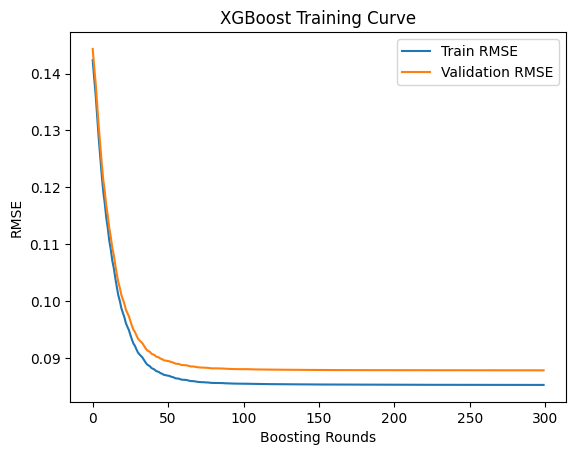

In [ ]:
train_pairs["cf_score"] = generate_cf_predictions(
    train_pairs,
    active_user_indices,
    pred_ratings,
    W_combined,
    b,
    user_bias,
  )

train_pairs["dl_score"] = generate_dl_predictions(
    train_pairs,
    model,
    user_profiles,
    game_features
  )

display(train_pairs)

xgb_model, history = train_xgboost(train_pairs, 300, 20)

plt.plot(history["train_loss"], label="Train RMSE")
plt.plot(history["val_loss"], label="Validation RMSE")
plt.xlabel("Boosting Rounds")
plt.ylabel("RMSE")
plt.title("XGBoost Training Curve")
plt.legend()
plt.show()

In [ ]:
recommendations = recommend_games_xgb(
    user_idx=2598,
    xgb_model=xgb_model,
    df_merged=df_merged_train,
    game_lookup=game_lookup,
    scaler=scaler,
    top_n=20,
    active_user_indices=active_user_indices,
    pred_ratings=pred_ratings,
    W_combined=W_combined,
    b=b,
    user_bias=user_bias,
    dl_model=model,
    user_profiles=user_profiles,
    game_features=game_features
)

for i, (game, hours) in enumerate(recommendations, 1):
   print(f"{i}. {game} (predicted hours: {hours:.1f})")

1. fallout 4 (predicted hours: 199.0)
2. borderlands 2 (predicted hours: 89.8)
3. dark souls ii (predicted hours: 79.5)
4. dark souls ii scholar of the first sin (predicted hours: 79.5)
5. metal gear solid v the phantom pain (predicted hours: 66.4)
6. borderlands the presequel (predicted hours: 63.3)
7. pillars of eternity (predicted hours: 46.7)
8. fairy fencer f (predicted hours: 41.2)
9. nba 2k16 (predicted hours: 40.0)
10. farming simulator 15 (predicted hours: 36.2)
11. fallout new vegas (predicted hours: 35.8)
12. final fantasy xiii (predicted hours: 31.8)
13. mount  blade warband (predicted hours: 30.4)
14. action  gameplay recording and streaming (predicted hours: 29.6)
15. dying light (predicted hours: 28.4)
16. bioshock infinite (predicted hours: 26.6)
17. saints row the third (predicted hours: 26.6)
18. hurtworld (predicted hours: 25.9)
19. the binding of isaac rebirth (predicted hours: 24.6)
20. dragon age origins (predicted hours: 24.5)


All thats left to do is clean up the notebook, test on a real steam profile, and compare models with NDCG and precision@10, remove softwares from the dataset


In [ ]:
def compute_ndcg_hours(df, preds, k=10):
    ndcgs = []
    for u, group in df.groupby("user_idx"):
        if group.shape[0] < 2:
            continue
        y_true = group["Hours_Or_Purchase"].values.reshape(1, -1)
        y_pred = preds[group.index].reshape(1, -1)
        ndcgs.append(ndcg_score(y_true, y_pred, k=k))
    return np.mean(ndcgs)

In [ ]:
test_cf_preds = generate_cf_predictions(df_merged_test, active_user_indices, pred_ratings, W_combined, b, user_bias)
test_dl_preds = generate_dl_predictions(df_merged_test, model, user_profiles, game_features)

df_merged_test["cf_score"] = test_cf_preds
df_merged_test["dl_score"] = test_dl_preds

dtest = xgb.DMatrix(df_merged_test[["cf_score", "dl_score"]].values)
test_xgb_preds = xgb_model.predict(dtest)



print(f"Collaborative Filtering NDCG@10: {100*compute_ndcg_hours(df_merged_test, test_cf_preds, k=10):.1f}%")
print(f"Content Based Filtering with DL NDCG@10: {100*compute_ndcg_hours(df_merged_test, test_dl_preds, k=10):.1f}%")
print(f"XGBoost Model NDCG@10: {100*compute_ndcg_hours(df_merged_test, test_xgb_preds, k=10):.1f}%")

Collaborative Filtering NDCG@10: 85.9%
Content Based Filtering with DL NDCG@10: 87.4%
XGBoost Model NDCG@10: 88.2%
